In [18]:
import os
import time
import numpy as np
from pathlib import Path
from collections import namedtuple
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import default_collate, DataLoader, Dataset, random_split

from torchvision.datasets import CelebA, FashionMNIST
import torchvision.transforms as T

In [19]:
class NoiseEmbedding(nn.Module):
    def __init__(self, cond_channels):
        super().__init__()
        self.register_buffer('weight', torch.randn(1, cond_channels // 2))

    def forward(self, input):
        f = 2 * torch.pi * input.unsqueeze(1) @ self.weight
        return torch.cat([f.cos(), f.sin()], dim=-1)


class Model(nn.Module):
    def __init__(
        self,
        image_channels,
        nb_channels,
        num_blocks,
        cond_channels,
    ) -> None:
        super().__init__()
        self.noise_emb = NoiseEmbedding(cond_channels)
        self.conv_in = nn.Conv2d(image_channels, nb_channels, kernel_size=3, padding=1)
        self.blocks = nn.ModuleList([ResidualBlock(nb_channels, cond_channels) for _ in range(num_blocks)])
        self.conv_out = nn.Conv2d(nb_channels, image_channels, kernel_size=3, padding=1)

    def forward(self, noisy_input, c_noise):
        cond = self.noise_emb(c_noise)
        x = self.conv_in(noisy_input)
        for block in self.blocks:
            x = block(x, cond)
        return self.conv_out(x)


class CondBatchNorm2d(nn.Module):
    def __init__(self, nb_channels, cond_channels):
        super().__init__()
        self.norm = nn.BatchNorm2d(nb_channels, affine=False)
        self.gamma = nn.Linear(cond_channels, nb_channels)
        self.beta = nn.Linear(cond_channels, nb_channels)

    def forward(self, x, cond):
        y = self.norm(x)
        gamma = self.gamma(cond)[:, :, None, None]
        beta = self.beta(cond)[:, :, None, None]
        return y * gamma + beta

class ResidualBlock(nn.Module):
    def __init__(self, nb_channels, cond_channels):
        super().__init__()
        self.norm1 = CondBatchNorm2d(nb_channels, cond_channels)
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1)
        self.norm2 = CondBatchNorm2d(nb_channels, cond_channels)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1)

    def forward(self, x, cond):
        y = self.conv1(F.relu(self.norm1(x, cond)))
        y = self.conv2(F.relu(self.norm2(y, cond)))
        return x + y

In [20]:
DataInfo = namedtuple('DataInfo', 'image_channels image_size num_classes sigma_data')
DataLoaders = namedtuple('DataLoaders', 'train valid')


def load_dataset_and_make_dataloaders(
        dataset_name,
        root_dir,
        batch_size,
        num_workers,
        pin_memory,
    ) -> Tuple[DataLoaders, DataInfo]:

    train_dataset, valid_dataset, data_info = load_dataset(dataset_name, root_dir)
    dl = make_dataloaders(train_dataset, valid_dataset, data_info.num_classes, batch_size, num_workers, pin_memory)
    return dl, data_info


def load_dataset(dataset_name='FashionMNIST', root_dir='data'):

    match dataset_name:

        case 'FashionMNIST':
            t = T.Compose([T.ToTensor(), T.Pad(2), T.Normalize(mean=(0.5,), std=(0.5,))])
            train_dataset = FashionMNIST(root_dir, download=True, transform=t)
            train_dataset, valid_dataset = random_split(train_dataset, [50000, 10000])
            num_classes = 10

        case 'CelebA':
            t = T.Compose([T.ToTensor(), T.CenterCrop(178), T.Resize(128, antialias=True), T.Normalize(mean=(0.5,), std=(0.5,))])
            train_dataset = CelebA(root_dir, download=True, transform=t)
            train_dataset, valid_dataset = random_split(train_dataset, [150000, 12770])
            num_classes = None

        case other:
            raise RuntimeError('Unknown dataset: ' + other)

    x, _ = next(iter(DataLoader(train_dataset, batch_size=10000, shuffle=True)))
    _, c, h, w = x.size()
    assert h == w
    sigma_data = x.std()

    return train_dataset, valid_dataset, DataInfo(c, h, num_classes, sigma_data)


def make_dataloaders(
        train_dataset,
        valid_dataset,
        num_classes,
        batch_size,
        num_workers,
        pin_memory,
    ) -> DataLoaders:

    collate_fn = default_collate if num_classes is not None else lambda batch: (default_collate(batch)[0], None)
    kwargs = {'collate_fn': collate_fn, 'num_workers': num_workers, 'persistent_workers': (num_workers > 0), 'pin_memory': pin_memory}

    return DataLoaders(
        train=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs),
        valid=DataLoader(valid_dataset, batch_size=2 * batch_size, **kwargs)
    )

In [21]:
[train, test], info = load_dataset_and_make_dataloaders("FashionMNIST", root_dir="data", batch_size=128, num_workers=4, pin_memory=True)

In [22]:
model = Model(info.image_channels, 128, 5, 32).to("cuda")

In [23]:
print("Number of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of trainable parameters: 1562753


In [24]:
def sample_sigma(n, loc=-1.2, scale=1.2, sigma_min=2e-3, sigma_max=80):
    return (torch.randn(n) * scale + loc).exp().clip(sigma_min, sigma_max)

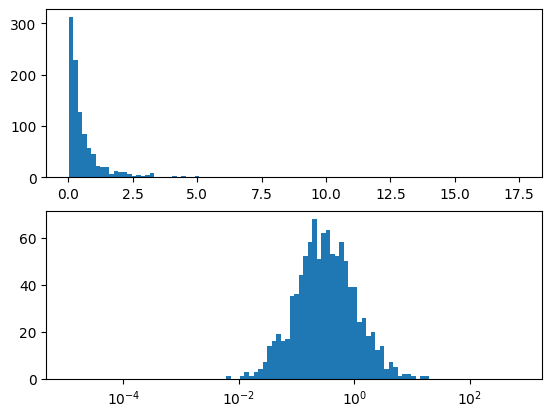

In [25]:
import math
sigma = sample_sigma(1000)

plt.subplot(211)
hist, bins, _ = plt.hist(sigma.tolist(), bins=100)

plt.subplot(212)
logbins = torch.logspace(math.log(bins[0]), math.log(bins[-1]), steps=len(bins))
plt.hist(sigma.tolist(), bins=logbins)
plt.xscale('log')

In [26]:
def build_sigma_schedule(steps, rho=7, sigma_min=2e-3, sigma_max=80):
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + torch.linspace(0, 1, steps) * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas

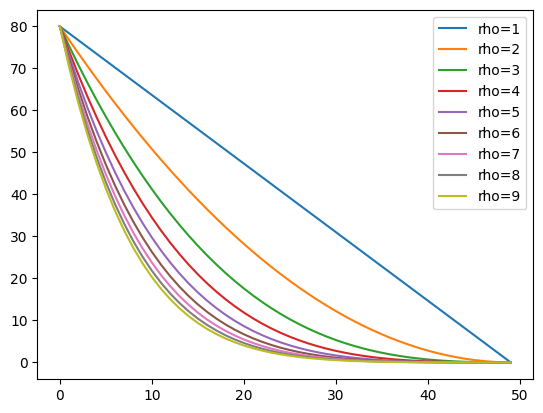

In [27]:
for rho in range(1, 10):
 sigmas = build_sigma_schedule(steps=50, sigma_min=2e-3,
sigma_max=80, rho=rho)
 plt.plot(sigmas.tolist(), label=f'rho={rho}')
plt.legend()
plt.show()

In [28]:
def make_c(sigma, sigma_data):
    ss = sigma**2
    sds = sigma_data**2
    sss = ss + sds
    ssss = torch.sqrt(sss)
    c_in = 1 / ssss
    c_out = sigma * sigma_data / ssss
    c_skip = sds / sss
    c_noise = torch.log(sigma) / 4
    return c_in.view(-1, 1, 1, 1), c_out.view(-1, 1, 1, 1), c_skip.view(-1, 1, 1, 1), torch.atleast_1d(c_noise)

In [ ]:
model.train()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.001)
sigma_schedule = build_sigma_schedule(50)
for epoch in range(150):
    n = 0
    total_loss = 0
    beg = time.perf_counter()
    for Y, _ in train:
        X = Y.clone()
        sigmas = np.random.choice(sigma_schedule, X.shape[0]) # todo:sample sigma
        sigmas = torch.from_numpy(sigmas)
        for i, sigma in enumerate(sigmas):
            X[i] += torch.normal(0, sigma, X.shape[1:])
        c_in, c_out, c_skip, c_noise = make_c(sigmas, info.sigma_data)
        output = model((X * c_in).to("cuda"), c_noise.to("cuda"))
        target = (Y - X * c_skip) / c_out
        loss = loss_fn(output, target.to("cuda"))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n += 1
        total_loss += loss.item()
    end = time.perf_counter()
    scheduler.step(total_loss)
    print(f"Epoch: {epoch}, Steps: {n}, Loss: {total_loss / n:.3f}, Time: {end - beg:.1f}")

Epoch: 0, Steps: 391, Loss: 0.802, Time: 92.1
Epoch: 1, Steps: 391, Loss: 0.472, Time: 92.9
Epoch: 2, Steps: 391, Loss: 0.441, Time: 92.2
Epoch: 3, Steps: 391, Loss: 0.423, Time: 91.8
Epoch: 4, Steps: 391, Loss: 0.414, Time: 93.1
Epoch: 5, Steps: 391, Loss: 0.407, Time: 92.4


In [ ]:
root = Path("/content/drive")

In [ ]:
drive.mount(str(root))

In [ ]:
path = root / "MyDrive" / "models"
model_path = path / "FashionMNIST"

In [ ]:
torch.save({'model_state_dict': model.state_dict()}, 'checkpoints/checkpoint.pth')

In [ ]:
mycheckpoint = torch.load('checkpoints/checkpoint.pth')

new_model = Model(info.image_channels, 128, 5, 0)
new_model.load_state_dict(mycheckpoint['model_state_dict'])

In [ ]:
new_model

In [ ]:
os.makedirs(path, exist_ok=True)
torch.save(model, model_path)
# model = torch.load(model_path).to("cuda")

In [ ]:
m = 6

In [ ]:
model.eval()
X = torch.normal(0, sigma_schedule[0], [m**2, info.image_channels, info.image_size, info.image_size])
for i, sigma in enumerate(sigma_schedule):
    c_in, c_out, c_skip, c_noise = make_c(sigma, info.sigma_data)
    sigma_next = 0 if i == len(sigma_schedule) - 1 else sigma_schedule[i + 1]
    with torch.no_grad():
        X_denoised = c_skip * X + c_out * model((X * c_in).to("cuda"), c_noise.to("cuda")).to("cpu")
        #x_denoised = D(x, sigma)
        # Where D(x, sigma) = cskip(sigma) * x + cout(sigma) * F(cin(sigma) * x, cnoise(sigma))
    d = (X - X_denoised) / sigma
    X = X + d * (sigma_next - sigma)

In [ ]:
X = X.clamp(-1, 1).add(1).div(2).mul(255).byte()
X = X.permute(0, 2, 3, 1)

<ipython-input-22-5515c95c8cf5>:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


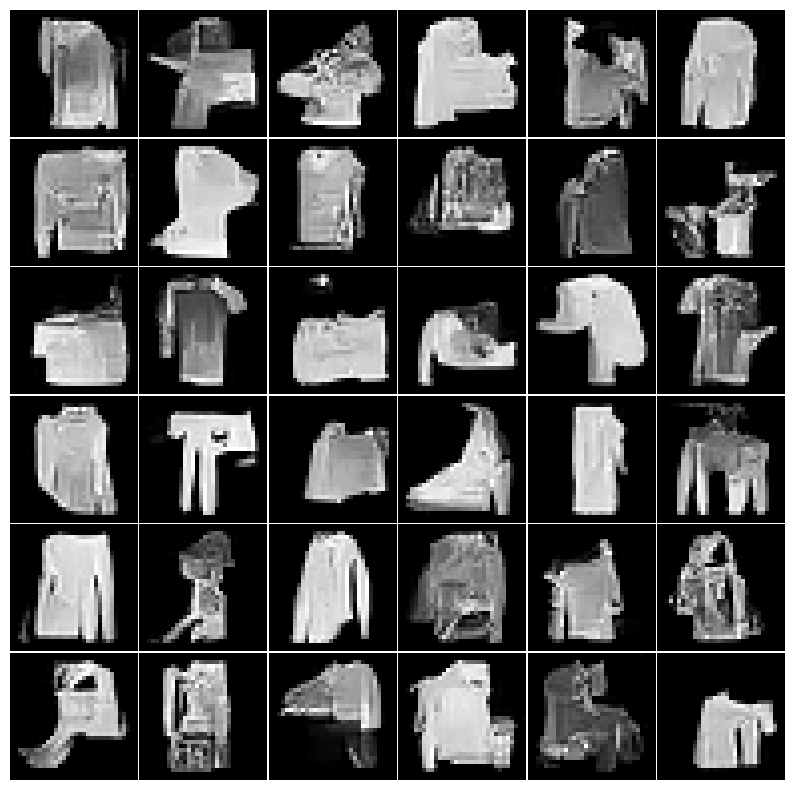

In [ ]:
fig, ax = plt.subplots(m, m, figsize=(10, 10), gridspec_kw={"wspace": 0.01, "hspace": 0.01})
for i in range(m):
  for j in range(m):
    ax[i][j].axis('off')
    ax[i][j].imshow(X[m * i + j], cmap="gray")
plt.tight_layout()

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
from torcheval.metrics import FrechetInceptionDistance

In [ ]:
FID = FrechetInceptionDistance().to("cuda")

In [ ]:
for Y, _ in test:
    FID.update(Y.add(1).div(2).repeat(1, 3, 1, 1), True)

In [ ]:
model.eval()
for _ in range(100):
    X = torch.normal(0, sigma_schedule[0], [100, info.image_channels, info.image_size, info.image_size])
    for i, sigma in enumerate(sigma_schedule):
        c_in, c_out, c_skip, c_noise = make_c(sigma, info.sigma_data)
        sigma_next = 0 if i == len(sigma_schedule) - 1 else sigma_schedule[i + 1]
        with torch.no_grad():
            X_denoised = c_skip * X + c_out * model((X * c_in).to("cuda"), c_noise.to("cuda")).to("cpu")
        d = (X - X_denoised) / sigma
        X = X + d * (sigma_next - sigma) #  Perform one step of Euler's method
    FID.update(X.clamp(-1, 1).add(1).div(2).repeat(1, 3, 1, 1), False)

In [ ]:
FID.compute().item()

54.52067565917969